# Markowitz Model
## Modern Portfolio Theory

[Example of Applying Modern Portfolio Theory (MPS)](https://www.investopedia.com/articles/company-insights/083016/example-applying-modern-portfolio-theory-mps.asp)

Key Assumptions of Modern Portfolio Theory:
* Investors attempt to maximize returns given their unique situation
* Asset returns are normally distributed
* Investors are rational and avoid unnecessary risk
* All investors have the same view on expected returns
* Taxes and trading costs are not considered
* Single investors are not sizable enough to influence market prices
* Unlimited amounts of capital can be borrowed at the risk-free rate
  
The Efficient Portfolio is the Portfolio that has the highest reward for a given level of risk or the lowest risk for a given return.

![](Images/efficient_portfolio.png)


In [18]:
import numpy as np
# import yahoo finance to pull stock and crypto data from
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as optimization
# bringing in these libraries in order to use a dynamic date selection - see sub_years
import datetime as dt
from datetime import date

In [19]:
# stocks we are going to handle

# lets come up with a way for the user to select an asset type (stock or crypto) and get the top 5 stocks or top 3 cryptos in order to build a portfolio
stocks = ['FB', 'AAPL', 'AMZN', 'NFLX', 'GOOG', 'TSLA', 'MSFT', 'BTC-USD']


In [20]:
# we want the user to focus on the assets they are wanting to analyze and not the amount of data the program is analyzing
# so in order to get the most relevant information we create a dynamic date range with a rolling 10 year window
# first we create a variable today and set it equal to the datetime libraries date.today() 
today = date.today()

# once we have todays date we can run a formula to replace the year output from the date.today() with whatever timeframe we enter
# in our program we will set this input at 10 years
def sub_years(today_date, years):
    try:
        return today_date.replace(year = today_date.year - years)
    except ValueError:
        return today_date + (date(today_date.year + years, 1, 1) - date(today_date.year, 1, 1))

In [21]:
# historical data - define START and END dates
# to calculate the start_date we must use the sub_years function defined above to get today's date and subtract 10 years
# then using the .strftime('%Y-%m-%d') we format it so that it can be passed to yahoo finance
start_date = sub_years(today, 10).strftime('%Y-%m-%d')
# for the end_date we just have to reformat the today variable with the .strftime('%Y-%m-%d') we format it so that it can be passed to yahoo finance 
end_date = today.strftime('%Y-%m-%d')

### IF WE ARE GOING TO ALLOW CRYPTO THEN WE NEED TO UPDATE THE TRADING DAYS TO 365 AND RERUN THE CALCS

# number of trading days in a year (stocks only)
num_tradings_days = 252

# set variable of amount of random w (different portfolios) we want to create
num_portfolios = 10000

In [22]:
# define a function download_data()
def download_data():
    # name of the stock (key) - stock values (2015-2021) as the values
    stock_data = {}

    for stock in stocks:
        ticker = yf.Ticker(stock)
        stock_data[stock] = ticker.history(start=start_date, end=end_date)['Close']
    return pd.DataFrame(stock_data)



In [23]:
# define a function show_data()
def show_data(data):
    data.plot(figsize=(20,10), grid=True, xlabel='Date', ylabel="Stock Price", title=f"Historical Price from {start_date} through {end_date}")
    plt.show()


In [24]:
# define return
def calculate_return(data):
    # NORMALIZATION - to measure all variables in comparable metric
    log_return = np.log(data/data.shift(1))
    # return [1:] takes out the null values from the first data point
    return log_return[1:]

In [25]:
# define annual metrics
def show_statistics(returns):
    print(returns.mean() * num_tradings_days)
    print(returns.cov() * num_tradings_days)

In [26]:
#
def show_mean_variance(returns, weights):
    portfolio_return = np.sum(returns.mean()*weights) * num_tradings_days
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov()*num_tradings_days, weights)))
    print(f"Expected portfolio mean (return): {portfolio_return}")
    print(f"Expected portfolio volatilit (standard deviation): {portfolio_volatility}")

In [27]:
def generate_portfolios(returns):
    portfolio_means = []
    portfolio_risks = []
    portfolio_weights = []

    for _ in range(num_portfolios):
        # if len(asset)

        w = np.random.random(len(stocks))
        w /= np.sum(w)
        portfolio_weights.append(w)
        portfolio_means.append(np.sum(returns.mean() * w) * num_tradings_days)
        portfolio_risks.append(np.sqrt(np.dot(w.T, np.dot(returns.cov() * num_tradings_days, w))))
    
    return np.array(portfolio_weights), np.array(portfolio_means), np.array(portfolio_risks)



In [28]:
def show_portfolios(returns, volatilities):
    plt.figure(figsize=(20,10))
    plt.scatter(volatilities, returns, c=returns/volatilities, marker='o')
    plt.grid(True)
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Returns')
    plt.colorbar(label='Sharpe Ratio')
    plt.show()

In [29]:
def statistics(weights, returns):
    portfolio_return = np.sum(returns.mean() * weights) * num_tradings_days
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * num_tradings_days, weights)))

    return np.array([portfolio_return, portfolio_volatility, portfolio_return/portfolio_volatility])

In [30]:
# scipy optimize module can find the minimum of a given function
# the maximum of a f(x) is the minimum of -f(x)
def min_function_sharpe(weights, returns):
    return -statistics(weights, returns)[2]

In [31]:
# what are the constraints? the sum of weights = 1
# f(x)=0 this is the function to minimize
def optimize_portfolio(weights, returns):
    # the sum of weights is 1
    cons = {'type': 'eq', 'fun': lambda x: np.sum(x) -1}
    # the weights can be 1 at most: 1 when 100% of money is invested inot a single stock
    bnds = tuple((0,1) for _ in range(len(stocks)))
    
    return optimization.minimize(
                fun=min_function_sharpe,
                x0=weights[0],
                args=returns,
                method='SLSQP',
                bounds=bnds,
                constraints=cons
                )

In [32]:
# print the Stocks and Weights into a manageable pd.DataFrame to be easier to read and export
def print_optimal_portfolio_dataframe(optimum, returns):
    # first create a variable to be passed into the new dataframe
    weights = optimum['x'].round(3)
    # create the new dataframe with index = stocks
    optimal_portfolio_weights_df = pd.DataFrame({'Weights %': weights}, index=stocks)
    
    # create another dataframe that holds the metrics we are tracking for our portfolio
    headers = ['Expected Returns', 'Expected Volatility', 'Expected Sharpe Ratio']
    stats = statistics(optimum['x'].round(3), returns)
    metrics = pd.DataFrame({"Metrics": stats}, index=headers)
    
    print(metrics)
    # the weights are ordered in the same order as the stocks from above so they will print side by side
    print(optimal_portfolio_weights_df)

In [33]:
def show_optimal_portfolio(opt, rets, portfolio_rets, portfolio_vols):
    plt.figure(figsize=(20,10))
    plt.style.use(['dark_background'])
    plt.scatter(portfolio_vols, portfolio_rets, c=portfolio_rets/portfolio_vols, marker='o')
    plt.grid(True)
    plt.rcParams.update({'font.size': 18})
    plt.title(f"Modern Portfolio Theory for {stocks}")
    plt.xlabel("Expected Volatility")
    plt.ylabel("Expected Return")
    plt.colorbar(label='Sharpe Ratio')
    plt.plot(statistics(opt['x'], rets)[1], statistics(opt['x'], rets)[0], 'r*', markersize=20.0)

                        Metrics
Expected Returns       0.289948
Expected Volatility    0.227528
Expected Sharpe Ratio  1.274341
         Weights %
FB           0.143
AAPL         0.000
AMZN         0.000
NFLX         0.029
GOOG         0.230
TSLA         0.070
MSFT         0.377
BTC-USD      0.152


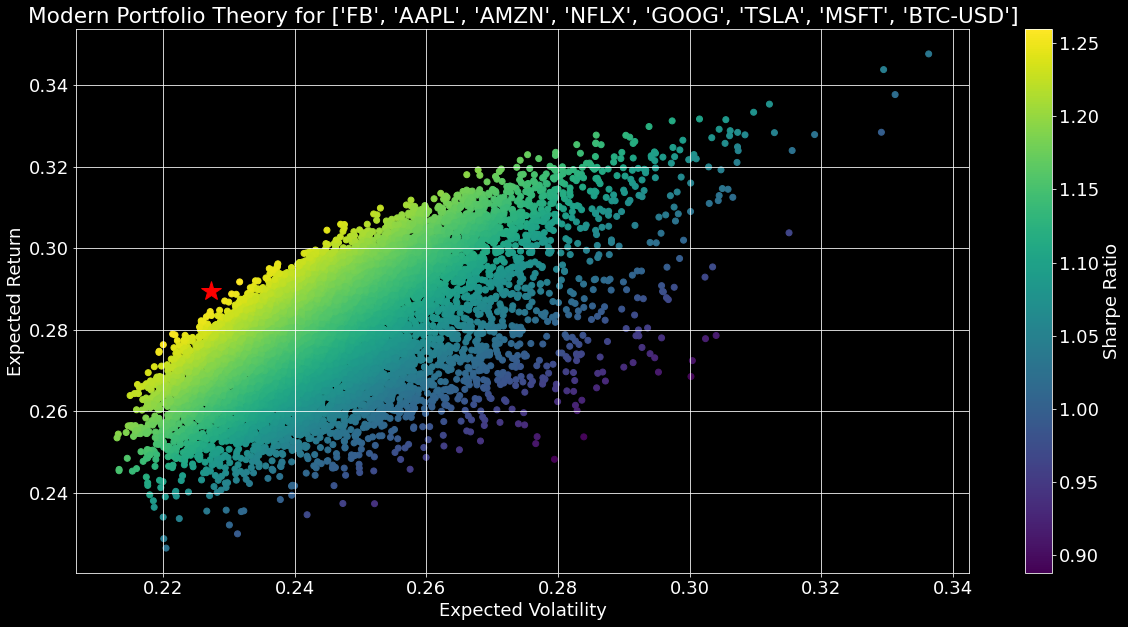

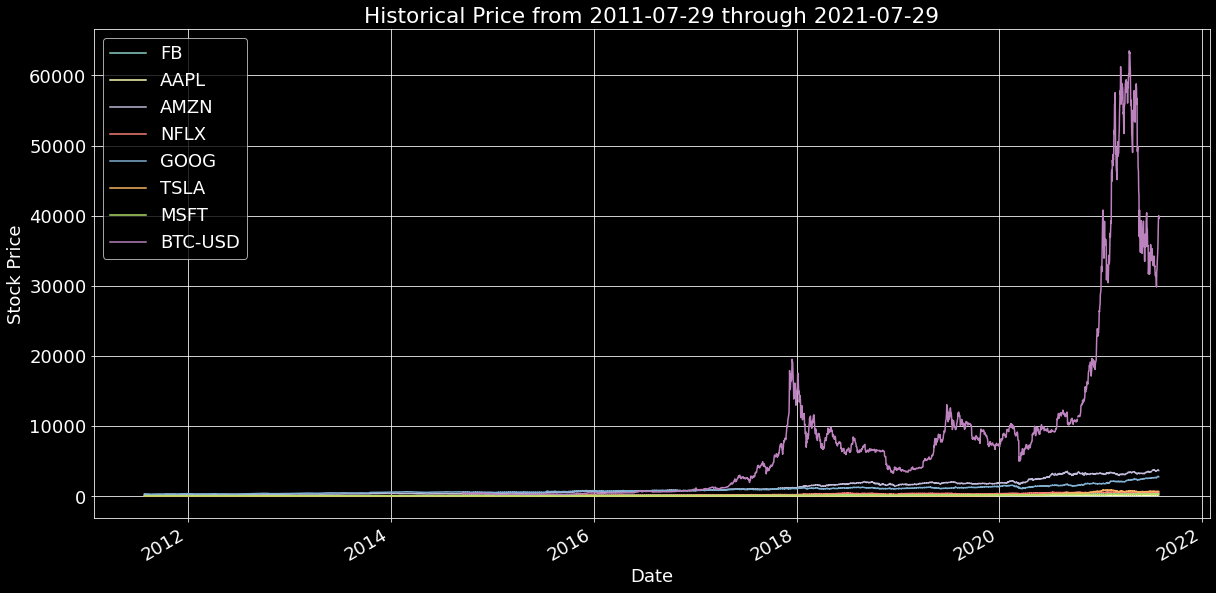

In [34]:
if __name__ == '__main__':
    dataset = download_data()
    
    log_daily_returns = calculate_return(dataset)

    portfolio_weights, means, risks = generate_portfolios(log_daily_returns)
    
    optimum = optimize_portfolio(portfolio_weights, log_daily_returns)

    print_optimal_portfolio_dataframe(optimum, log_daily_returns)

    show_optimal_portfolio(optimum, log_daily_returns, means, risks)

    show_data(dataset)